<a href="https://colab.research.google.com/github/danielpark98/CorpFinance_WRDS_Python/blob/main/Information%20Asymmetry%20Measures%20from%20CRSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wrds
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime
from pathlib import Path

db=wrds.Connection()

crsp_1621= db.raw_sql("""
    SELECT *
    FROM crsp.dsf
    WHERE date >= '2019-01-01'
        AND date <= '2021-12-31'
        AND prc IS NOT NULL
        AND cfacpr IS NOT NULL
        AND cfacshr IS NOT NULL
        AND shrout IS NOT NULL
        AND prc > 1
        AND vol > 0
        AND askhi IS NOT NULL
        AND bidlo IS NOT NULL
        AND openprc IS NOT NULL
        AND askhi IS NOT NULL
        AND bidlo IS NOT NULL
""")

db.close()

data = crsp_1621
data['date'] = pd.to_datetime(data['date'])
data.head()

  Using cached wrds-3.1.6-py3-none-any.whl (12 kB)
  Using cached psycopg2_binary-2.9.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached SQLAlchemy-1.4.49-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.19
    Uninstalling SQLAlchemy-2.0.19:
      Successfully uninstalled SQLAlchemy-2.0.19
Enter your WRDS username [root]:danielpark98
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,vol,ret,bid,ask,shrout,cfacpr,cfacshr,openprc,numtrd,retx
0,46603210,10026.0,7976.0,10433.0,3.0,2052.0,2019-01-02,139.119995,144.039993,141.000000,112825.0,-0.024829,140.759995,141.000000,18774.0,1.0,1.0,143.419998,1648.0,-0.024829
1,72913210,10032.0,7980.0,10437.0,3.0,3670.0,2019-01-02,50.349998,52.099998,51.740002,208765.0,0.012921,51.740002,51.790001,30992.0,1.0,1.0,50.360001,3309.0,0.012921
2,77467X10,10044.0,7992.0,10454.0,3.0,2060.0,2019-01-02,8.250000,8.630000,8.630000,8472.0,0.012887,8.570000,8.630000,5949.0,1.0,1.0,8.400000,66.0,0.012887
3,41043F20,10051.0,7999.0,10468.0,1.0,4813.0,2019-01-02,18.299999,19.110001,18.879999,164082.0,-0.003694,18.860001,18.910000,36848.0,1.0,1.0,18.760000,NaN,-0.003694
4,00621210,10065.0,20023.0,0.0,1.0,6722.0,2019-01-02,12.380000,12.776600,12.650000,328758.0,0.002377,12.660000,12.670000,100868.0,1.0,1.0,12.420000,NaN,0.002377


In [ ]:
# Group by 'permno' and 'date' (to monthly)
grouped = data.groupby([data['permno'], data['date'].dt.to_period('M')])

# Calculate monthly volume
monthly_volume = grouped['vol'].sum()

# Calculate shares outstanding
monthly_shares = grouped['shrout'].mean()

# Calculate turnover with adjusted shares
monthly_data = pd.DataFrame(monthly_volume / (monthly_shares*1000), columns=['turnover'])

# Calculate other measures
monthly_data['daily_spread_highlow'] = grouped.apply(lambda x: np.mean(x['askhi'] - x['bidlo'])).values

# Calculate the HL_Spread measure
def calculate_hl_spread(group):
    beta = (np.log(group['askhi'] / group['bidlo']) ** 2).mean()
    gamma = (np.log(group['askhi'].max() / group['bidlo'].min()) ** 2)
    alpha = (np.sqrt(2*beta) - np.sqrt(beta)) / (3 - 2*np.sqrt(2)) - np.sqrt(gamma / (3 - 2*np.sqrt(2)))
    spread = 2*(np.exp(alpha) - 1) / (1 + np.exp(alpha))
    return spread

monthly_data['HL_spread'] = grouped.apply(calculate_hl_spread).values
monthly_data['HL_spread'] = abs(monthly_data['HL_spread'] / 10)

# Calculate Roll measure
def calculate_roll(group):
    price_changes = np.log(group['prc']).diff()
    cov = price_changes.cov(price_changes.shift())
    return 2 * np.sqrt(-cov) if cov < 0 else 0

monthly_data['roll'] = grouped.apply(calculate_roll).values
# Calculate Amihud measure
def calculate_amihud(group):
    dollar_volume = (group['prc'] * group['vol']) / 1_000_000
    return (group['ret'].abs() / dollar_volume).mean()

monthly_data['amihud'] = grouped.apply(calculate_amihud).values
# Calculate Realized_Volatility
monthly_data['realized_volatility'] = grouped.apply(lambda x: np.sum(x['ret'] ** 2)).values
# Calculate Return_STD
monthly_data['return_std'] = grouped['ret'].std().values
monthly_data = monthly_data.reset_index()
monthly_data.to_csv("/content/drive/MyDrive/crsp_1621.csv", index=False)
monthly_data

KeyboardInterrupt: ignored

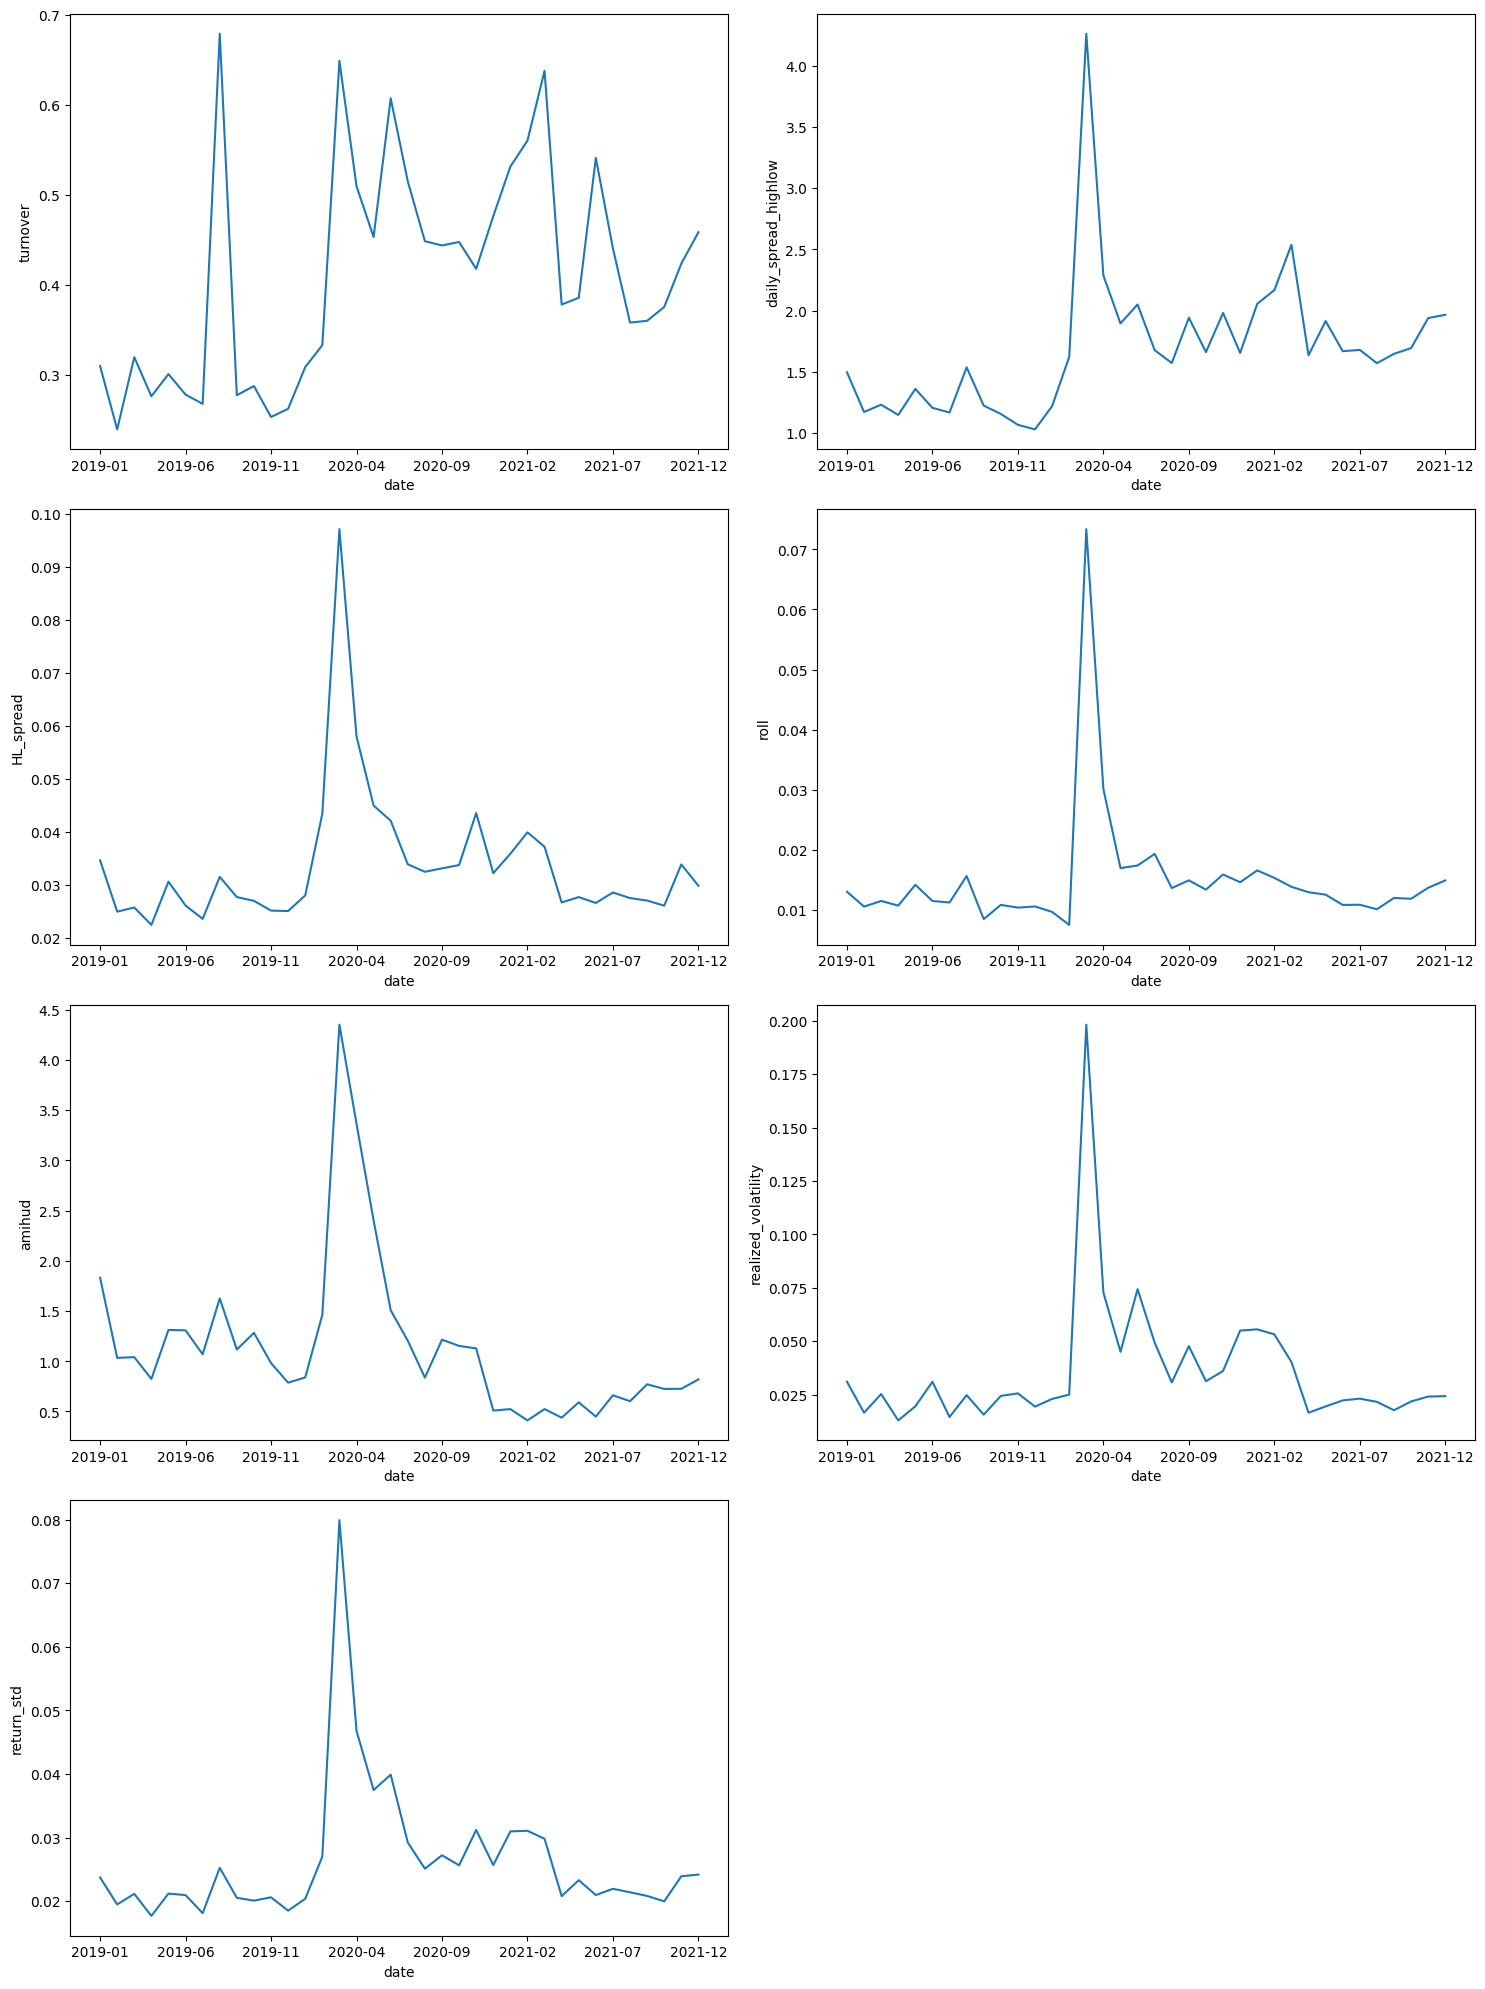

In [ ]:
import matplotlib.pyplot as plt

df_new = pd.read_csv("/content/drive/MyDrive/crsp_1621.csv")

# Convert 'date' to datetime

# Set the figure size
plt.figure(figsize=(15, 20))

# Create a separate line plot for each measure
for i, column in enumerate(df_new.drop(['permno', 'date'], axis=1).columns, start=1):
    plt.subplot(4, 2, i)
    df_new.groupby('date')[column].mean().plot()
    plt.ylabel(column)

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()
